# Explore Real-Time Data on Iguazio via Integrated Notebooks

## Read NoSQL Data as Real-Time DataFrame Stream
`frames` is a high-performance streaming API into Iguazio database presented as Pandas DataFrame support multiple backend data models (Key/value, Time-series, Stream, Object/file).

In [1]:
import pandas as pd
import v3io_frames as v3f
client = v3f.Client('framesd:8081', container='bigdata')

In [2]:
client.execute(backend='kv', table='stocks/stocks_kv', command='infer')

""


In [3]:
kvdf = client.read(backend='kv', table='stocks/stocks_kv')#, filter='volume > 1000000')
kvdf.head()

,last_updated,price,volume
symbol,,,
MSFT,2020-09-22 11:21:02-04:00,203.05,0.0
AAPL,2020-09-22 11:21:02-04:00,109.75,0.0
INTC,2020-09-22 11:21:01-04:00,49.59,0.0
GOOG,2020-09-22 11:20:53-04:00,1444.93,0.0
AMZN,2020-09-22 11:21:01-04:00,3036.47,0.0


## Analyze Real-Time Data Using Spark Streaming, SQL, and ML
The Iguazio database appears to Spark as native Spark Data Frames. Spark is auto-provisioned and configured on iguazio platform, no DevOps is required.

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Iguazio Integration demo").getOrCreate()

In [5]:
spark.read.format("io.iguaz.v3io.spark.sql.kv").load("v3io://bigdata/stocks/stocks_kv").show()

+------+-------+------+--------------------+
|volume|  price|symbol|        last_updated|
+------+-------+------+--------------------+
|   0.0|1445.14|  GOOG|2020-09-22 11:25:...|
|   0.0| 203.05|  MSFT|2020-09-22 11:21:...|
|   0.0| 109.75|  AAPL|2020-09-22 11:21:...|
|   0.0|  49.59|  INTC|2020-09-22 11:21:...|
|   0.0|3036.47|  AMZN|2020-09-22 11:21:...|
+------+-------+------+--------------------+



## Run Interactive SQL Queries on Real-Time Data
Support full ANSI SQL through native integration of Apache Presto over iguazio database. The same data appears through different APIs (Spark, Presto SQL, native Pandas, DynamoDB like API)

In [6]:
%sql SELECT * FROM bigdata."stocks/stocks_kv"

Done.


volume,symbol,last_updated,price
0.0,GOOG,2020-09-22 11:25:51-04:00,1445.14
0.0,MSFT,2020-09-22 11:26:02-04:00,203.07
0.0,AAPL,2020-09-22 11:26:05-04:00,110.04
0.0,INTC,2020-09-22 11:26:05-04:00,49.54
0.0,AMZN,2020-09-22 11:26:04-04:00,3036.48


## Read the Time-Series data (in iguazio TSDB) as Pandas DataFrame
Use database side aggregations, joins and filtering on the real-time metrics data

In [27]:
# Read Time-Series aggregates from the DB (returned as a data stream, use concat to assemble the frames)
tsdf = client.read(backend='tsdb', query="select avg(*), max(*), min(*) from 'stocks/stocks_tsdb'", start='now-2d', end='now', multi_index=True)
tsdf.head()

avg(price)  avg(sentiment)  \
time                             symbol                               
2020-09-20 15:39:38.254000+00:00 MSFT     203.35381       -0.072568   
                                 AAPL     110.80450        0.014489   
                                 GOOG    1443.79050       -0.140962   
                                 GOOGL      0.00000       -0.250000   
                                 AMZN    3027.86000       -0.116970   

                                          avg(volume)  max(price)  \
time                             symbol                             
2020-09-20 15:39:38.254000+00:00 MSFT    30700.095238      204.87   
                                 AAPL    90334.400000      112.09   
                                 GOOG     2629.450000     1450.99   
                                 GOOGL       0.000000        0.00   
                                 AMZN     3737.200000     3050.00   

                                         max(sentiment)  max(volume)  \
time                             symbol                                
2020-09-20 15:39:38.254000+00:00 MSFT          0.710382     546266.0   
                                 AAPL          0.880654    1806688.0   
                                 GOOG          0.983125      52589.0   
                                 GOOGL        -0.250000          0.0   
                                 AMZN          0.978172      74744.0   

                                         min(price)  min(sentiment)  \
time                             symbol                               
2020-09-20 15:39:38.254000+00:00 MSFT        202.11       -0.963122   
                                 AAPL        109.75       -0.995809   
                                 GOOG       1431.92       -0.726049   
                                 GOOGL         0.00       -0.250000   
                                 AMZN       2960.47       -0.974066   

                                         min(volume)  
time                             symbol               
2020-09-20 15:39:38.254000+00:00 MSFT            0.0  
                                 AAPL            0.0  
                                 GOOG            0.0  
                                 GOOGL           0.0  
                                 AMZN            0.0

## Run interesting Analysis On Real-Time Data
Compare stock price volatility between different companies

/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:479: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(self.ylim)
/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


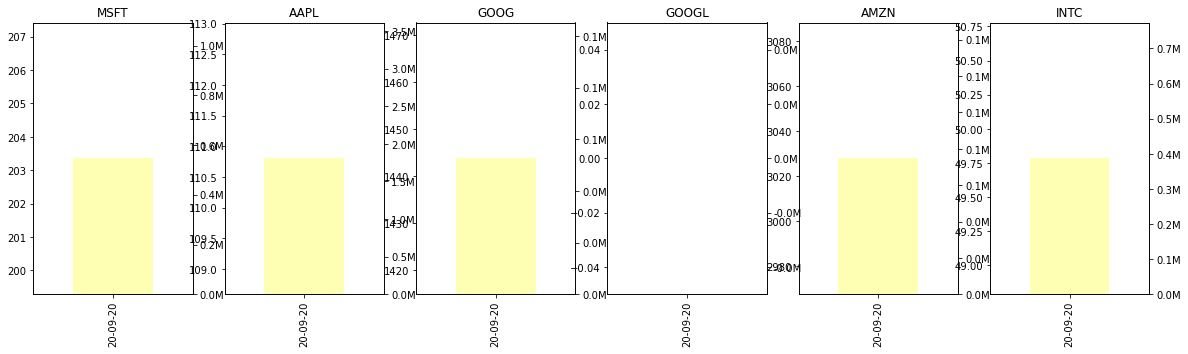

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import Formatter, FuncFormatter
import numpy as np

pricesdf = tsdf[['avg(price)','max(volume)']]
pricesdf.columns = ['price', 'volume']

stock_symbols = pricesdf.index.unique(level='symbol')

class TimeseriesFormatter(Formatter):
    def __init__(self, dates, fmt='%y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''

        return self.dates[ind].strftime(self.fmt)

fig, axarr = plt.subplots(1,len(stock_symbols))
for sym, ax in zip(stock_symbols, axarr):
    curr_df = pricesdf.xs(sym, level='symbol')
    curr_df.index = pd.to_datetime(curr_df.index).tz_localize(None)

    # xticks for one day
    xticks = pd.date_range(start=curr_df.index.min(), end=curr_df.index.max(), freq='D')

    # Make sure x-axis has only date ranges for which we have data
    xticks = [curr_df.index.get_loc(x, method='nearest') for x in xticks]
    ax.xaxis.set_major_formatter(TimeseriesFormatter(curr_df.index))
    curr_df.reset_index(inplace=True, drop=True)
    ylim = (curr_df['price'].min() * 0.98, curr_df['price'].max() * 1.02)
    iter_xticks = iter(xticks[1:] + [curr_df.index.max()])
    
    # Color map
    cm = plt.get_cmap('Set3')
    
    # Grey bars every other date
    for a in zip(iter_xticks, iter_xticks):
        ax.fill_between(a, ylim[0], ylim[1], alpha=0.2, color='grey')
    
    # Price
    ax = curr_df['price'].plot(ax=ax,
                               kind='area',
                               xticks=xticks,
                               ylim=ylim,
                               title=sym,
                               rot=45,
                               color=cm.colors[0],
                               figsize=[20,5])

    #Volume
    curr_df['volume'].plot(ax=ax,
                           kind='bar',
                           xticks=xticks,
                           secondary_y=True,
                           color=cm.colors[1])
    ax.right_ax.set_ylim(0,curr_df['volume'].max()*2)
    ax.right_ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: '%0.1fM' % (x*1e-6)))
    ax.right_ax.grid(False)

## Read the Sentiments Feed as Pandas DataFrame
Streaming data generated in by nuclio functions can be read in real-time or historically. It can be distributed to multiple workers for scalability via sharding/partitioning. 

In [29]:
streamdf = client.read(backend='stream', table='stocks/stocks_stream',seek='earliest', shard_id='0')
streamdf.head(15)

,content,link,sentiment,stream_time,symbol,time
seq_number,,,,,,
1,By Shreyashi Sanyal and Devik Jain\n(Reuters) ...,https://www.investing.com/news/stock-market-ne...,-0.533333,2020-09-22 13:37:38.860707964+00:00,GOOGL,2020-09-22 00:00:00
2,By Lawrence Hurley\nWASHINGTON (Reuters) - Jus...,https://www.investing.com/news/politics/us-sup...,-0.227273,2020-09-22 13:37:38.863252957+00:00,GOOGL,2020-09-22 00:00:00
3,By David Shepardson and Nandita Bose\nWASHINGT...,https://www.investing.com/news/technology-news...,-0.500000,2020-09-22 13:37:38.864908263+00:00,GOOGL,2020-09-22 00:00:00
4,HONG KONG (Reuters) - Chinese tech giant Tence...,https://www.investing.com/news/economy/chinese...,-0.700000,2020-09-22 13:37:38.866414324+00:00,GOOGL,2020-09-22 00:00:00
5,By Shreyashi Sanyal and Devik Jain\n(Reuters) ...,https://www.investing.com/news/stock-market-ne...,-0.533333,2020-09-22 13:37:49.082518153+00:00,MSFT,2020-09-22 00:00:00
6,By Josh Horwitz and Brenda Goh\nSHANGHAI (Reut...,https://www.investing.com/news/stock-market-ne...,-0.320000,2020-09-22 13:37:49.084677300+00:00,MSFT,2020-09-22 00:00:00
7,By Geoffrey Smith \nInvesting.com -- The spect...,https://www.investing.com/news/stock-market-ne...,-0.500000,2020-09-22 13:37:49.086697495+00:00,MSFT,2020-09-22 00:00:00
8,HANOI (Reuters) - Taiwan s Pegatron (TW:4938...,https://www.investing.com/news/technology-news...,-0.250000,2020-09-22 13:37:49.088827978+00:00,MSFT,2020-09-22 00:00:00
9,By Echo Wang and Yingzhi Yang\nNEW YORK/BEIJIN...,https://www.investing.com/news/stock-market-ne...,-0.500000,2020-09-22 13:37:49.090644404+00:00,MSFT,2020-09-21 00:00:00


## Save Any Data "To Go" as a CSV file (or other formats)

In [30]:
streamdf.to_csv('mystream.csv')